<a href="https://colab.research.google.com/github/ananya1331/SER-notebooks/blob/main/ECAPA_TDNN_Demo_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q yt-dlp

In [ ]:
print("Installing packages...")
!pip install -q --upgrade pip
!pip install -q torch==2.4.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cpu
!pip install -q yt-dlp librosa soundfile matplotlib seaborn scikit-learn speechbrain

print("\n✓ Installation complete!")
print("\n⚠️ IMPORTANT: Go to Runtime > Restart runtime")
print("Then run the main code in the next cell.")

Installing packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 27.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.24.0+cpu requires torch==2.9.0, but you have torch 2.4.0+cpu which is incompatible.

✓ Installation complete!

⚠️ IMPORTANT: Go to Runtime > Restart runtime
Then run the main code in the next cell.


In [ ]:
import os
import torch
import torchaudio
import numpy as np
import librosa
import soundfile as sf
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

print("✓ All imports successful!\n")

def download_youtube_audio(url: str, output_path: str = "./audio") -> str:
    import yt_dlp
    os.makedirs(output_path, exist_ok=True)

    ydl_opts = {
        'format': 'bestaudio/best',
        'postprocessors': [{'key': 'FFmpegExtractAudio', 'preferredcodec': 'wav'}],
        'outtmpl': os.path.join(output_path, '%(title)s.%(ext)s'),
        'quiet': True,
        'no_warnings': True,
    }

    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(url, download=True)
        filename = ydl.prepare_filename(info)
        audio_file = filename.rsplit('.', 1)[0] + '.wav'
    return audio_file

class SpeakerVerificationSystem:
    def __init__(self):
        from speechbrain.pretrained import EncoderClassifier
        print("Loading ECAPA-TDNN model...")
        self.classifier = EncoderClassifier.from_hparams(
            source="speechbrain/spkrec-ecapa-voxceleb",
            savedir="pretrained_models/spkrec-ecapa-voxceleb"
        )
        self.speaker_name = None
        print("✓ Model loaded!\n")

    def extract_embedding(self, audio_path: str) -> np.ndarray:
        signal, sr = torchaudio.load(audio_path)
        if sr != 16000:
            signal = torchaudio.transforms.Resample(sr, 16000)(signal)
        with torch.no_grad():
            embedding = self.classifier.encode_batch(signal)
        return embedding.squeeze().cpu().numpy()

    def enroll_speaker(self, audio_files: List[str], speaker_name: str):
        print(f"Enrolling: {speaker_name}")
        self.speaker_name = speaker_name
        embeddings = [self.extract_embedding(f) for f in audio_files]
        self.enrollment_embedding = np.mean(embeddings, axis=0)
        print(f"✓ Enrolled with {len(audio_files)} samples\n")

    def verify_speaker(self, test_audio: str, threshold: float = 0.25):
        test_emb = self.extract_embedding(test_audio)
        similarity = cosine_similarity(
            self.enrollment_embedding.reshape(1, -1),
            test_emb.reshape(1, -1)
        )[0][0]
        return {
            'speaker_name': self.speaker_name,
            'similarity': float(similarity),
            'score': float(similarity * 100),
            'verified': similarity > threshold,
            'threshold': threshold,
            'confidence': 'HIGH' if abs(similarity - threshold) > 0.15 else 'MEDIUM' if abs(similarity - threshold) > 0.08 else 'LOW'
        }

def split_audio_into_segments(audio_file: str, segment_duration: int = 10, output_dir: str = "./segments"):
    os.makedirs(output_dir, exist_ok=True)
    audio, sr = librosa.load(audio_file, sr=16000)
    segment_length = segment_duration * sr
    segments = []
    for i in range(0, len(audio), segment_length):
        segment = audio[i:i+segment_length]
        if len(segment) >= sr * 3:
            segment_file = os.path.join(output_dir, f"segment_{i//segment_length:03d}.wav")
            sf.write(segment_file, segment, sr)
            segments.append(segment_file)
    return segments

def visualize_verification_results(results):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Speaker Verification - ECAPA-TDNN', fontsize=16, fontweight='bold')

    scores = [r['score'] for r in results]
    similarities = [r['similarity'] for r in results]
    verified = [r['verified'] for r in results]

    axes[0, 0].bar(range(len(scores)), scores, color=['green' if v else 'red' for v in verified], alpha=0.7)
    axes[0, 0].axhline(y=results[0]['threshold']*100, color='orange', linestyle='--')
    axes[0, 0].set_title('Verification Scores')

    axes[0, 1].hist(similarities, bins=15, color='skyblue', edgecolor='black')
    axes[0, 1].set_title('Similarity Distribution')

    verified_count = sum(verified)
    axes[1, 0].pie([verified_count, len(verified)-verified_count],
                   labels=['Verified', 'Failed'], colors=['green', 'red'], autopct='%1.1f%%')

    conf_counts = {}
    for r in results:
        conf_counts[r['confidence']] = conf_counts.get(r['confidence'], 0) + 1
    axes[1, 1].bar(conf_counts.keys(), conf_counts.values())

    plt.tight_layout()
    plt.show()

    print(f"\nVerified: {verified_count}/{len(results)} ({verified_count/len(results)*100:.1f}%)")
    print(f"Avg Score: {np.mean(scores):.2f}")

def run_speaker_verification_demo(youtube_urls, speaker_name="Ranveer Allahbadia", num_enrollment=3):
    print("="*60)
    print("SPEAKER VERIFICATION DEMO")
    print("="*60)

    audio_files = []
    for i, url in enumerate(youtube_urls[:6]):
        print(f"\nDownloading {i+1}/6...")
        try:
            audio_files.append(download_youtube_audio(url))
        except Exception as e:
            print(f"Error: {e}")

    all_segments = []
    for audio_file in audio_files:
        all_segments.extend(split_audio_into_segments(audio_file))

    verifier = SpeakerVerificationSystem()
    verifier.enroll_speaker(all_segments[:num_enrollment], speaker_name)

    results = []
    for seg in all_segments[num_enrollment:num_enrollment+10]:
        results.append(verifier.verify_speaker(seg))

    visualize_verification_results(results)
    return verifier, results

YOUTUBE_URLS = [
    "https://youtu.be/e-sycEw4gyc",
    "https://youtu.be/OcISVEh1jyw",
    "https://youtu.be/8kS99Dqj6us",
    "https://youtu.be/Mwpsr1iHStY",
    "https://youtu.be/q3k8Ax8gBAI",
    "https://youtu.be/M7x6A9hMeUo",
]

print("Run: verifier, results = run_speaker_verification_demo(YOUTUBE_URLS)")

✓ All imports successful!

Run: verifier, results = run_speaker_verification_demo(YOUTUBE_URLS)


SPEAKER VERIFICATION DEMO








DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _speechbrain_save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _speechbrain_load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _recover
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


Loading ECAPA-TDNN model...


hyperparams.yaml: 0.00B [00:00, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/hyperparams.yaml' -> '/content/pretrained_models/spkrec-ecapa-voxceleb/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _load
DEBUG:speechbrain.utils.checkpoints:Registered parameter transfer hook for _load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load_if_possible
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embeddin

embedding_model.ckpt:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/embedding_model.ckpt' -> '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


mean_var_norm_emb.ckpt:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/mean_var_norm_emb.ckpt' -> '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


classifier.ckpt:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/classifier.ckpt' -> '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt
INFO:speechbrain.utils.fetching:Fetch label_encoder.txt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


label_encoder.txt: 0.00B [00:00, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/label_encoder.txt' -> '/content/pretrained_models/spkrec-ecapa-voxceleb/label_encoder.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["label_encoder"] = /content/pretrained_models/spkrec-ecapa-voxceleb/label_encoder.ckpt
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: embedding_model, mean_var_norm_emb, classifier, label_encoder
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): embedding_model -> /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): mean_var_norm_emb -> /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from l

✓ Model loaded!

Enrolling: Ranveer Allahbadia
✓ Enrolled with 3 samples



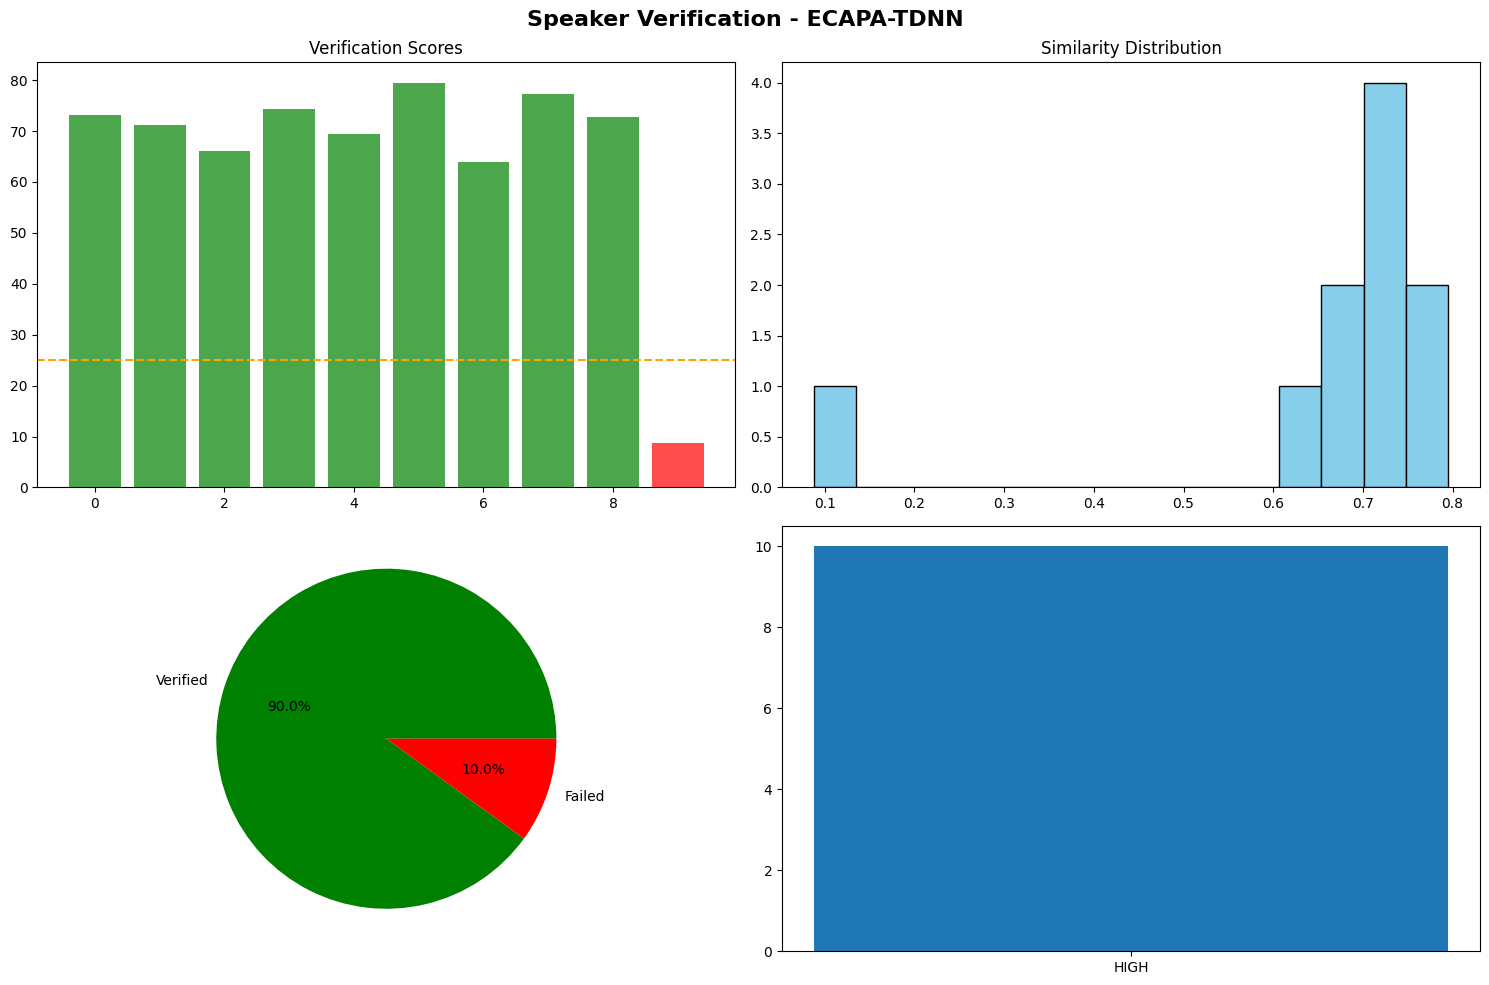


Verified: 9/10 (90.0%)
Avg Score: 65.63


In [ ]:
verifier, results = run_speaker_verification_demo(YOUTUBE_URLS)